In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

In [69]:
# create training set
np.random.seed(7777)
size = 500
train_range = (-10, 10)

X, Y = datasets.make_blobs(n_samples=size, centers=4, cluster_std=1.2, 
                           center_box=train_range, random_state=37)

In [70]:
# construct and train the model
torch.manual_seed(99999)

m, n = X.shape
h = 20  # num. hidden units
k = 4  # num. classes


class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU()
        )

        self.clf = nn.Linear(h, k, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
    
model = Model()    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

for it in range(5000):
    y = model(X_train)
    l = F.cross_entropy(y, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
        
print(f'Loss: {l.item():.3f}')

Loss: 0.043


In [71]:
# Test data
size = 50
test_range = (-15, 15)
test_rng = np.linspace(*test_range, size)

X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T
X_test = torch.from_numpy(X_test).float()

In [72]:
# the function to plot the confidence plot
def plot(X, Y, X1_test, X2_test, Z, test_range):
    cmap = 'Blues'
    plt.figure(figsize=(6, 5))

    im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=np.arange(0.3, 1.01, 0.1))
    plt.colorbar(im)
    
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='violet', edgecolors='k', linewidths=0.5)

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);

    plt.show();

In [93]:
# Exact Hessian using PyTorch's autograd. Credits due to Felix Dangel.
from hessian import exact_hessian
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal


W = list(model.parameters())[-1]
shape_W = W.shape


# Use BackPACK to get the Kronecker-factored last-layer covariance
extend(model.clf)
loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

loss = loss_func(model(X_train), y_train)

with backpack(extensions.KFAC()):
    loss.backward()

# The Kronecker-factored Hessian of the negative log-posterior
A, B = W.kfac

# The weight decay used for training is the Gaussian prior's precision
prec0 = 5e-4

# The posterior covariance's Kronecker factors
U = torch.inverse(A + sqrt(prec0)*torch.eye(shape_W[0]))
V = torch.inverse(B + sqrt(prec0)*torch.eye(shape_W[1]))

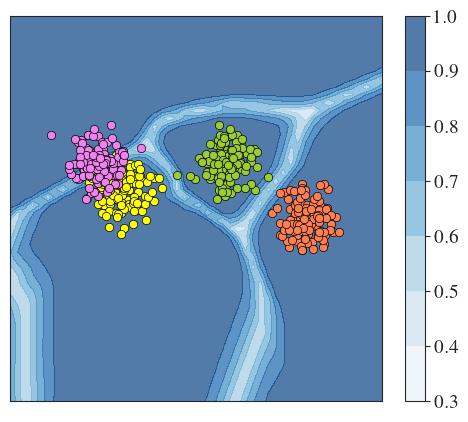

In [95]:
model.eval()

with torch.no_grad():
    py_map = F.softmax(model(X_test), 1).squeeze().numpy()

conf = py_map.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

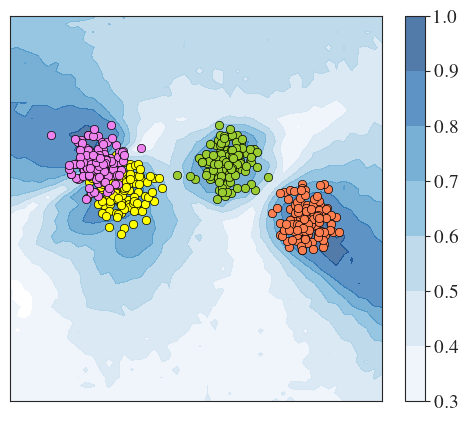

In [94]:
@torch.no_grad()
def predict(x):
    phi = model.feature_extr(x)
    
    # MAP prediction
    m = phi @ W.T
    
    # v is the induced covariance. 
    # See Appendix B.1 of https://arxiv.org/abs/2002.10118 for the detail of the derivation.
    v = torch.diag(phi @ V @ phi.T).reshape(-1, 1, 1) * U
        
    # The induced distribution over the output (pre-softmax)
    output_dist = MultivariateNormal(m, v)

    # MC-integral
    n_sample = 1000
    py = 0

    for _ in range(n_sample):
        out_s = output_dist.rsample()
        py += torch.softmax(out_s, 1)

    py /= n_sample

    return py.numpy()


# Get the posterior covariance and make prediction
py = predict(X_test)

# Confidence
conf = py.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

In [76]:
def predict_with_sigmoid_bound(x):
    phi = model.feature_extr(x)
    phi.requires_grad_() # Ensure phi tracks gradients

    m = phi @ W.T  # Ensure logits require gradients
    print("m.requires_grad:", m.requires_grad)  # Debugging check

    # Compute \tilde{f}_{\theta, k}(x)
    tilde_f = []
    for k in range(m.shape[1]):  
        mask = torch.arange(m.shape[1]).to(m.device)  # Ensure correct device
        mask = mask[mask != k]  # Get valid indices

        log_sum_exp = torch.logsumexp(m.gather(1, mask.unsqueeze(0).expand(m.shape[0], -1)), dim=-1, keepdim=True)

        tilde_f_k = m[:, k:k+1] - log_sum_exp  

        print(f"tilde_f_k for class {k} requires_grad:", tilde_f_k.requires_grad)  # Debugging check

        tilde_f.append(tilde_f_k)
    
    tilde_f = torch.cat(tilde_f, dim=-1)  

    print("tilde_f requires_grad:", tilde_f.requires_grad)  # Should be True

    # Compute gradients of \tilde{f}_{\theta, k}(x)
    grad_tilde_f = []
    for k in range(m.shape[1]):  
        grad_k = torch.autograd.grad(tilde_f[:, k].sum(), phi, retain_graph=True)[0]
        grad_tilde_f.append(grad_k.norm(dim=-1, keepdim=True))  

    grad_tilde_f = torch.cat(grad_tilde_f, dim=-1)  

    # Compute Hessian-based variance v
    #v = torch.einsum("bk,kj,bj->bk", grad_tilde_f, V, grad_tilde_f) * U  
    #v = (torch.diag(phi @ V @ phi.T).reshape(-1, 1, 1) * U)
    #print(v.shape)


    # Select the smallest entry in v
    #lambda_min_v = v.min(dim=-1, keepdim=True).values 
    #eigenvalues = torch.linalg.eigvalsh(v)  # Compute all eigenvalues for each sample
    #lambda_min_v = eigenvalues.min(dim=-1, keepdim=True).values  # Select the smallest one
    #print(lambda_min_v.shape)

    lambda_max_U = torch.linalg.eigvalsh(U).max()
    lambda_max_V = torch.linalg.eigvalsh(V).max()
    lambda_max_H = lambda_max_U * lambda_max_V
    min_grad_norm_sq = torch.norm(grad_tilde_f, dim=-1, p=2).pow(2).min(dim=-1, keepdim=True).values



    # Compute uncertainty-adjusted scaling
    #uncertainty_scale = 1 + torch.sqrt((torch.pi / 8) * lambda_min_v)
    uncertainty_scale = 1+ torch.sqrt((torch.pi / 8) * lambda_max_H * min_grad_norm_sq)
    # Compute final adjusted logits
    z_k = tilde_f / uncertainty_scale  

    # Compute softmax probabilities
    q_k = torch.sigmoid(z_k)  # Apply sigmoid to each class score
    py = q_k / q_k.sum(dim=-1, keepdim=True)  # Normalize across classes


    return py.detach().numpy()


In [77]:
print(conf)

[0.33517233 0.30134293 0.33092892 ... 0.4403856  0.4621875  0.43568504]


In [195]:
# the function to plot the confidence plot
def plot_concen(X, Y, X1_test, X2_test, Z, test_range):
    cmap = 'Blues'
    plt.figure(figsize=(6, 5))

    im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=np.arange(0.001, 0.51, 0.05))
    plt.colorbar(im)
    
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='violet', edgecolors='k', linewidths=0.5)

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);

    plt.show();

m.requires_grad: True
tilde_f_k for class 0 requires_grad: True
tilde_f_k for class 1 requires_grad: True
tilde_f_k for class 2 requires_grad: True
tilde_f_k for class 3 requires_grad: True
tilde_f requires_grad: True


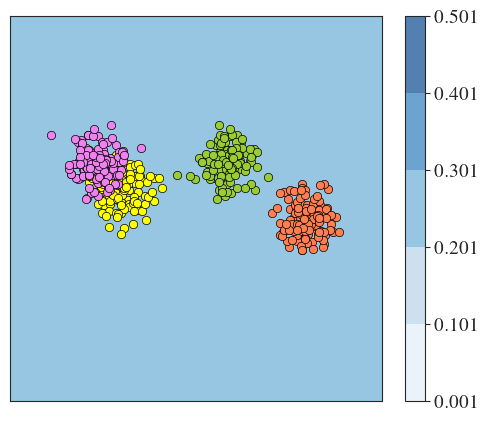

In [79]:
py = predict_with_sigmoid_bound(X_test)
# Get the posterior covariance and make prediction
#py = predict(X_test)

# Confidence
conf = py.max(1)

plot_concen(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

Test for different precision

In [227]:
# construct and train the model
torch.manual_seed(99999)

m, n = X.shape
h = 20  # num. hidden units
k = 4  # num. classes
prec0 = 8e-3

class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU()
        )

        self.clf = nn.Linear(h, k, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
    
model = Model()    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay= prec0) # change the weight decay accordingly

for it in range(5000):
    y = model(X_train)
    l = F.cross_entropy(y, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
        
print(f'Loss: {l.item():.3f}')

Loss: 0.052


In [228]:
# Exact Hessian using PyTorch's autograd. Credits due to Felix Dangel.
from hessian import exact_hessian
from backpack import extend, backpack, extensions
from torch.distributions.multivariate_normal import MultivariateNormal


W = list(model.parameters())[-1]
shape_W = W.shape


# Use BackPACK to get the Kronecker-factored last-layer covariance
extend(model.clf)
loss_func = extend(nn.CrossEntropyLoss(reduction='sum'))

loss = loss_func(model(X_train), y_train)

with backpack(extensions.KFAC()):
    loss.backward()

# The Kronecker-factored Hessian of the negative log-posterior
A, B = W.kfac

# The weight decay used for training is the Gaussian prior's precision
#prec0 = 5e-4
prec0 = 8e-3

# The posterior covariance's Kronecker factors
U = torch.inverse(A + sqrt(prec0)*torch.eye(shape_W[0]))
V = torch.inverse(B + sqrt(prec0)*torch.eye(shape_W[1]))

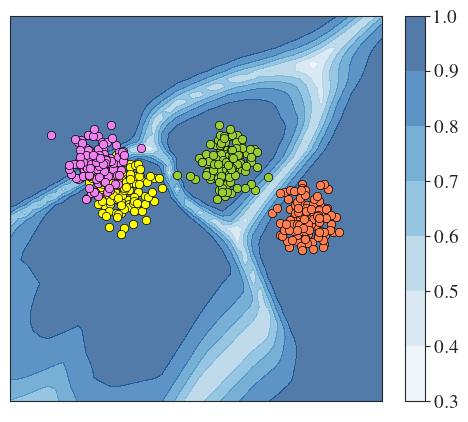

In [229]:
model.eval()

with torch.no_grad():
    py_map = F.softmax(model(X_test), 1).squeeze().numpy()

conf = py_map.max(1)

plot(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

In [230]:
def predict_with_sigmoid_bound(x):
    phi = model.feature_extr(x)
    phi.requires_grad_() # Ensure phi tracks gradients

    m = phi @ W.T  # Ensure logits require gradients
    print("m.requires_grad:", m.requires_grad)  # Debugging check

    # Compute \tilde{f}_{\theta, k}(x)
    tilde_f = []
    for k in range(m.shape[1]):  
        mask = torch.arange(m.shape[1]).to(m.device)  # Ensure correct device
        mask = mask[mask != k]  # Get valid indices

        log_sum_exp = torch.logsumexp(m.gather(1, mask.unsqueeze(0).expand(m.shape[0], -1)), dim=-1, keepdim=True)

        tilde_f_k = m[:, k:k+1] - log_sum_exp  

        print(f"tilde_f_k for class {k} requires_grad:", tilde_f_k.requires_grad)  # Debugging check

        tilde_f.append(tilde_f_k)
    
    tilde_f = torch.cat(tilde_f, dim=-1)  

    print("tilde_f requires_grad:", tilde_f.requires_grad)  # Should be True

    # Compute gradients of \tilde{f}_{\theta, k}(x)
    grad_tilde_f = []
    for k in range(m.shape[1]):  
        grad_k = torch.autograd.grad(tilde_f[:, k].sum(), phi, retain_graph=True)[0]
        grad_tilde_f.append(grad_k.norm(dim=-1, keepdim=True))  

    grad_tilde_f = torch.cat(grad_tilde_f, dim=-1)  

    # Compute Hessian-based variance v
    #v = torch.einsum("bk,kj,bj->bk", grad_tilde_f, V, grad_tilde_f) * U  
    #v = (torch.diag(phi @ V @ phi.T).reshape(-1, 1, 1) * U)
    #print(v.shape)


    # Select the smallest entry in v
    #lambda_min_v = v.min(dim=-1, keepdim=True).values 
    #eigenvalues = torch.linalg.eigvalsh(v)  # Compute all eigenvalues for each sample
    #lambda_min_v = eigenvalues.min(dim=-1, keepdim=True).values  # Select the smallest one
    #print(lambda_min_v.shape)

    lambda_max_U = torch.linalg.eigvalsh(U).max()
    lambda_max_V = torch.linalg.eigvalsh(V).max()
    lambda_max_H = lambda_max_U * lambda_max_V
    print(grad_tilde_f.shape)
    print((torch.norm(grad_tilde_f, dim=-1, p=2).pow(2)).shape)
    #min_grad_norm_sq = torch.norm(grad_tilde_f, dim=-1, p=2).pow(2).min(dim=-1, keepdim=True).values
    min_grad_norm_sq = grad_tilde_f.pow(2).min(dim=-1, keepdim=True).values  # Shape: (batch_size, 1)
    print(min_grad_norm_sq.shape)



    # Compute uncertainty-adjusted scaling
    #uncertainty_scale = 1 + torch.sqrt((torch.pi / 8) * lambda_min_v)
    uncertainty_scale = 1+ torch.sqrt((torch.pi / 8) * lambda_max_H * min_grad_norm_sq)
    # Compute final adjusted logits
    z_k = tilde_f / uncertainty_scale  

    # Compute softmax probabilities
    q_k = torch.sigmoid(z_k)  # Apply sigmoid to each class score
    py = q_k / q_k.sum(dim=-1, keepdim=True)  # Normalize across classes


    return py.detach().numpy()

m.requires_grad: True
tilde_f_k for class 0 requires_grad: True
tilde_f_k for class 1 requires_grad: True
tilde_f_k for class 2 requires_grad: True
tilde_f_k for class 3 requires_grad: True
tilde_f requires_grad: True
torch.Size([2500, 4])
torch.Size([2500])
torch.Size([2500, 1])


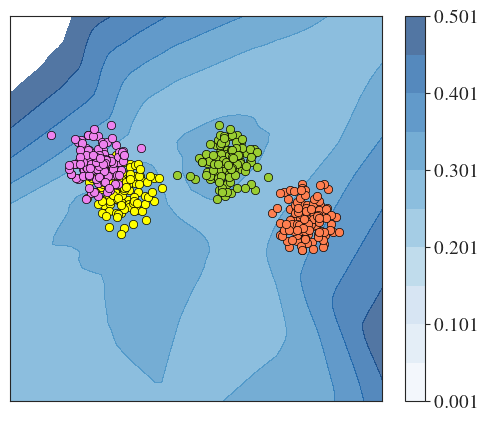

In [231]:
py = predict_with_sigmoid_bound(X_test)
# Get the posterior covariance and make prediction
#py = predict(X_test)

# Confidence
conf = py.max(1)

plot_concen(X, Y, X1_test, X2_test, conf.reshape(size, size), test_range)

In [186]:
print(conf)

[0.2800704  0.27913085 0.2781824  ... 0.28535706 0.29128104 0.29814583]
